In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
## Load dataset
data_path = "../../../Rings_2D"
OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()

NUM_DATASETS, N, D = OB.shape
K = 3
MCMC_SIZE = 10
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))
NUM_EPOCHS = 300
NUM_HIDDEN = 32
NUM_NSS = 8
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
DEVICE = 0

RECON_SIGMA = torch.ones(1) * 0.1
RADI = torch.ones(1) * 2.0
lg2pi = torch.log(torch.ones(1) * 2 * math.pi)

if CUDA:
    with torch.cuda.device(DEVICE):
        lg2pi = lg2pi.cuda().to(DEVICE)
PATH = 'ag--phase3-mu'

In [3]:
from global_enc_mu_v2 import *
from decoder_v2 import *
# initialization
enc_mu = Enc_mu(K, D, NUM_HIDDEN, NUM_NSS, CUDA, DEVICE)
dec_x = Dec_x(D, NUM_HIDDEN, RECON_SIGMA, CUDA, DEVICE)
if CUDA:
    with torch.cuda.device(DEVICE):
        enc_mu.cuda()
        dec_x.cuda()
optimizer =  torch.optim.Adam(list(dec_x.parameters())+list(enc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [4]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    ELBO = 0.0
    EUBO = 0.0
    ESS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        state = STATE[batch_indices]
        angle = ANGLE[batch_indices]
        embed = shuffler(torch.cat((ob, state, angle), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            with torch.cuda.device(DEVICE):
                embed = embed.cuda()
        ob = embed[:, :, :, :2]
        state = embed[:, :, :, 2:-1]
        angle = embed[:, :, :, -1].unsqueeze(-1)
        q_mu, p_mu = enc_mu.forward(ob, state, angle)
        mu = q_mu['means'].value
        p_recon = dec_x(ob, state, angle, mu)
        ll = p_recon['likelihood'].log_prob.sum(-1)
        log_recon = torch.cat([((state.argmax(-1)==k).float() * ll).sum(-1).unsqueeze(-1) for k in range(K)], -1) # S * B * K
        log_q = q_mu['means'].log_prob.sum(-1)
        log_p = p_mu['means'].log_prob.sum(-1) + log_recon
        log_w = log_p.detach() - log_q
        w = torch.softmax(log_w, 0).detach()
        loss_phi = (w.detach() * (- log_q)).sum(0).sum(-1).mean()
#         loss_theta = (- ll).sum(-1).mean()
        loss_theta = (w.detach() * (- log_p)).sum(0).sum(-1).mean() 
        elbo = log_w.sum(-1).mean().detach()
        eubo = (w * log_w).sum(0).sum(-1).mean().detach()
        
#         loss_phi = (w.detach() * (- log_q)).sum(0).mean()
#         loss_theta = (w.detach() * (- log_p)).sum(0).mean() 
#         elbo = log_w.mean().detach()
#         eubo = (w * log_w).sum(0).mean().detach()
        ess = (1 / (w ** 2).sum(0)).mean()
        loss_phi.backward(retain_graph=True)
        loss_theta.backward()
        optimizer.step()
        ELBO += elbo.detach()
        EUBO += eubo.detach()
        ESS += ess
    time_end = time.time()
    print('epoch=%d, eubo=%.4f, elbo=%.4f, ess=%.4f (%ds)' % (epoch,  EUBO / NUM_BATCHES, ELBO / NUM_BATCHES, ESS / NUM_BATCHES, time_end - time_start))

epoch=0, eubo=-17121.2070, elbo=-45649.6211, ess=1.0229 (11s)
epoch=1, eubo=-1208.2314, elbo=-14571.2920, ess=1.0449 (11s)
epoch=2, eubo=-796.7600, elbo=-12981.8633, ess=1.0822 (10s)
epoch=3, eubo=-591.0240, elbo=-12363.8408, ess=1.1175 (8s)
epoch=4, eubo=-401.1506, elbo=-11014.5830, ess=1.1511 (11s)
epoch=5, eubo=-274.4922, elbo=-10111.2188, ess=1.1754 (11s)
epoch=6, eubo=-162.5285, elbo=-9017.9062, ess=1.2105 (11s)
epoch=7, eubo=-119.6835, elbo=-8704.3721, ess=1.2217 (11s)
epoch=8, eubo=-94.8968, elbo=-7699.9766, ess=1.2635 (11s)
epoch=9, eubo=-5.4313, elbo=-7284.9053, ess=1.2846 (9s)
epoch=10, eubo=14.1994, elbo=-6755.0127, ess=1.3021 (8s)
epoch=11, eubo=53.7191, elbo=-6013.9233, ess=1.3369 (8s)
epoch=12, eubo=115.3908, elbo=-5553.3184, ess=1.3494 (8s)
epoch=13, eubo=145.4417, elbo=-5042.7329, ess=1.3841 (11s)
epoch=14, eubo=178.4118, elbo=-4751.0503, ess=1.4268 (10s)
epoch=15, eubo=169.3733, elbo=-4430.5718, ess=1.4360 (8s)
epoch=16, eubo=174.8831, elbo=-4338.2441, ess=1.4273 (8s)


KeyboardInterrupt: 

In [5]:
def plot_final_samples(ob, mu, state, recon, K, PATH, bound):
    page_width = 25
    B, N, D = ob.shape
    plt.rc('axes',edgecolor='#eeeeee')
    gs = gridspec.GridSpec(int(B / 5), 5)
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
    fig = plt.figure(figsize=(page_width,page_width*4/5))
    colors = ['#EE7733', 'm', '#0077BB', '#009988']
    for b in range(B):
        ax = fig.add_subplot(gs[int(b/5), int(b%5)])
        assignments = state[b].argmax(-1)
        ax.scatter(recon[b, :, 0], recon[b, :, 1], c='k',alpha=0.2)
        for k in range(K):
            ob_k = ob[b][np.where(assignments == k)]
            ax.scatter(ob_k[:, 0], ob_k[:, 1], c=colors[k], s=6, alpha=0.8)
            ax.set_ylim([-bound, bound])
            ax.set_xlim([-bound, bound])
#             ax.set_xticks([])
#             ax.set_yticks([])
            ax.scatter(mu[b, k, 0], mu[b, k, 1], c=colors[k], marker='X')

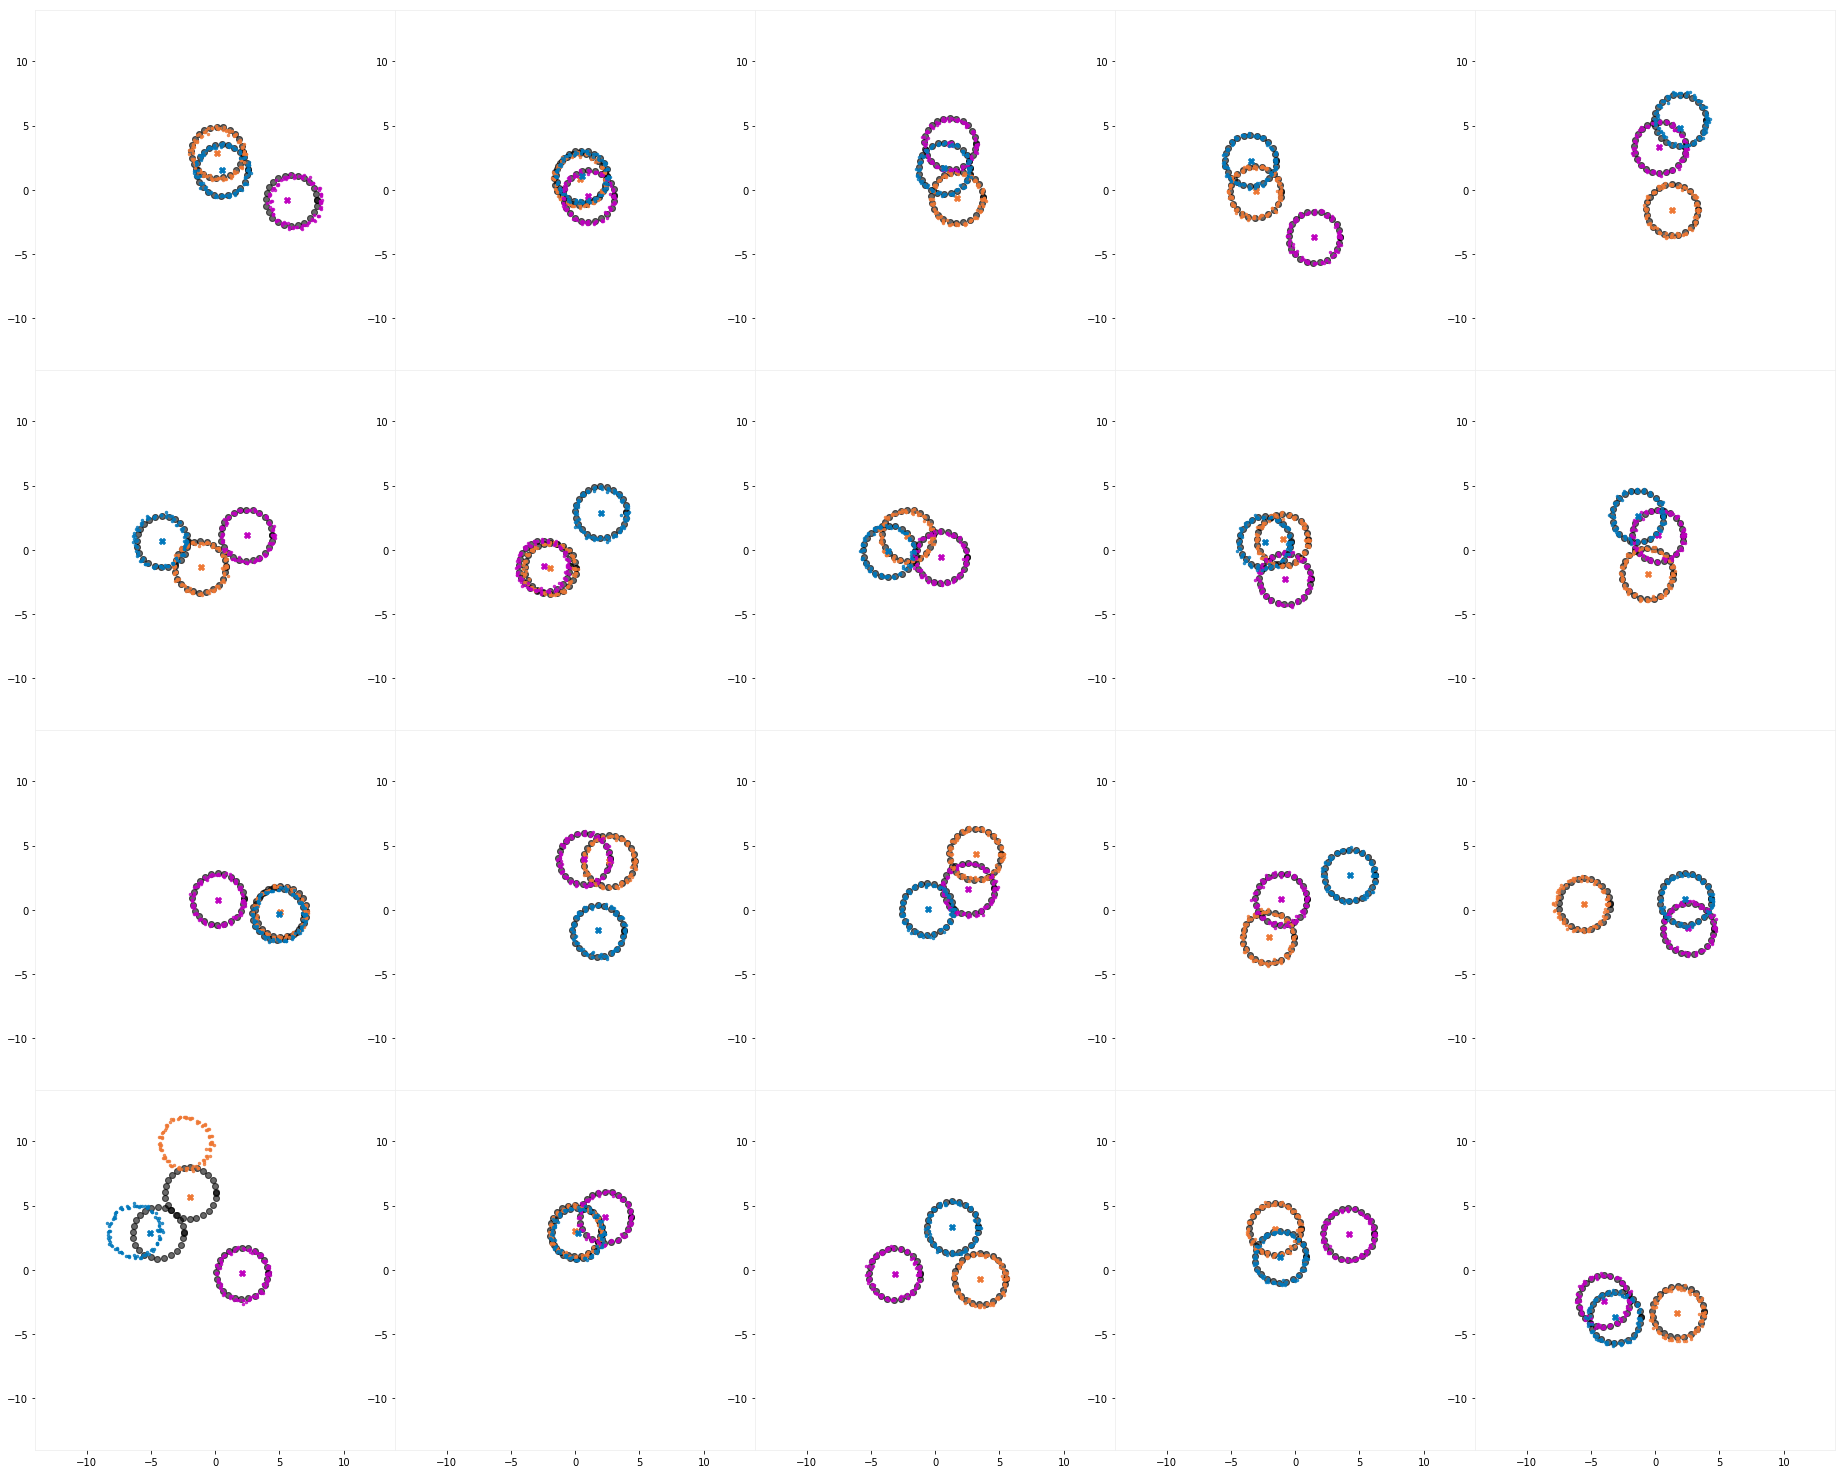

In [6]:
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
state = STATE[batch_indices]
angle = ANGLE[batch_indices]
mu_true = MU[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
embed = shuffler(torch.cat((ob, state, angle), -1)).repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    with torch.cuda.device(DEVICE):
        embed = embed.cuda()
        mu_true = mu_true.cuda()
ob = embed[:, :, :, :2]
state = embed[:, :, :, 2:-1]
angle = embed[:, :, :, -1].unsqueeze(-1)
q_mu, p_mu = enc_mu.forward(ob, state, angle)
mu = q_mu['means'].value
p_recon = dec_x(ob, state, angle, mu)
recon_mu = p_recon['likelihood'].dist.loc[0].cpu().data.numpy()
# recon_mu = p_recon['likelihood'].dist.loc
# recon_mu_centered = (recon_mu - global_to_local(mu, state))[0].cpu().data.numpy()
state_true = state[0].cpu().data.numpy()
mu_mu = q_mu['means'].dist.loc[0].cpu().data.numpy()
test_ob = ob[0].cpu().data.numpy()

mu_true = mu_true[0].cpu().data.numpy()
plot_final_samples(test_ob, mu_mu, state_true, recon_mu, K, PATH, 14)

In [ ]:
a = recon_mu_centered[0]
a